In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Data Analysis

# By County Analysis

In [3]:
# Connect SQLite.
dbconn = sqlite3.connect('../data/IowaLiquorSales.db')
cursor = dbconn.cursor()

# Pull Store database.
query = '''SELECT Sales.TransactionID, Sales.Date, Sales.StoreID, Store.StoreType, Sales.ProductID, Product.CategoryGroup, Sales.VendorID, Store.County, Store.lat, Store.lng, County.Year, County.Population, County.UNEMPLOYMENT_RATE, Sales.VolumeSold_Liters, Sales.Sale_Dollars
              FROM (((Sales 
              INNER JOIN Store ON Sales.StoreID=Store.StoreID)
              INNER JOIN County ON County.County=Store.County)
              INNER JOIN Product ON Sales.ProductID=Product.ProductID)
              WHERE Sales.Date BETWEEN '2021-01-01' AND '2021-12-31' 
              AND County.Year = Sales.Year;'''
cursor.execute(query)
result1 = cursor.fetchall()
cursor.close()
dbconn.close()

In [4]:
# Put the database in a data frame format.
temp1 = pd.DataFrame(result1, columns = ['TransactionID',
                                            'Date',
                                            'StoreID',
                                            'StoreType',
                                            'ProductID',
                                            'CategoryGroup',
                                            'VendorID',
                                            'County',
                                            'lat',
                                            'lng',
                                            'Year',
                                            'Population',
                                            'Unemployment_Rate',
                                            'VolumeSold_Liters',
                                            'Sale_Dollars'])

In [5]:
temp1.head()

,TransactionID,Date,StoreID,StoreType,ProductID,CategoryGroup,VendorID,County,lat,lng,Year,Population,Unemployment_Rate,VolumeSold_Liters,Sale_Dollars
0,INV-41517100002,2021-11-01,5417,Food & Grocery,36308,vodka,434,linn,41.88875,-91.67497,2021,230479,4.9,10.50,64.56
1,INV-41518800037,2021-11-01,4921,Food & Grocery,19061,whisky,65,linn,41.96451,-91.73978,2021,230479,4.9,0.05,10.50
2,INV-41518900014,2021-11-01,5687,Food & Grocery,11296,whisky,260,linn,41.96442,-91.72973,2021,230479,4.9,9.00,298.68
3,INV-41521200068,2021-11-01,2648,Food & Grocery,86250,liqueur,434,polk,41.56108,-93.77478,2021,504735,4.2,9.00,48.12
4,INV-41523800012,2021-11-01,4379,Convenience,52596,brandy,205,polk,41.58511,-93.78953,2021,504735,4.2,3.75,48.75


## Stores Locations Mini Table

In [6]:
map_stores0 = temp1.drop_duplicates(subset='StoreID', keep='first')
map_stores = map_stores0[['StoreID','County','lat','lng']]

In [7]:
map_stores.head()

,StoreID,County,lat,lng
0,5417,linn,41.88875,-91.67497
1,4921,linn,41.96451,-91.73978
2,5687,linn,41.96442,-91.72973
3,2648,polk,41.56108,-93.77478
4,4379,polk,41.58511,-93.78953


In [8]:
# convert the lat and lng coordinates to geometry
import geopandas as gpd
from shapely.geometry import Point, Polygon

map_stores["lat"] = map_stores["lat"].astype('float')
map_stores["lng"] = map_stores["lng"].astype('float')

geometry = [Point(xy) for xy in zip( map_stores["lng"], map_stores["lat"])]
geometry[:3]

crs = "EPSG:4326"

# create new geo-DataFrame
store_geo = gpd.GeoDataFrame(map_stores,crs = crs,
                         geometry = geometry)

/tmp/ipykernel_6025/3030766482.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_stores["lat"] = map_stores["lat"].astype('float')
/tmp/ipykernel_6025/3030766482.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_stores["lng"] = map_stores["lng"].astype('float')


In [9]:
store_geo.head()

,StoreID,County,lat,lng,geometry
0,5417,linn,41.88875,-91.67497,POINT (-91.67497 41.88875)
1,4921,linn,41.96451,-91.73978,POINT (-91.73978 41.96451)
2,5687,linn,41.96442,-91.72973,POINT (-91.72973 41.96442)
3,2648,polk,41.56108,-93.77478,POINT (-93.77478 41.56108)
4,4379,polk,41.58511,-93.78953,POINT (-93.78953 41.58511)


## County Table

In [10]:
more_county = pd.read_csv('../data/more_county.csv')

In [11]:
more_county.rename(columns = {'Percent_CollegeGraduates (2015-2019)':'Percent_CollegeGraduates',
                              'UnemploymentRate (2021)':'UnemploymentRate_2021',
                              'Median_Household_Income (2015-2019)':'Median_Household_Income_2019',
                              'Median_GrossRent (2015-2019)':'Median_GrossRent_2019',
                              'Population Estimate (2021)':'Population_Estimate_2021',
                              'Population Estimate (22-29 years)':'Population Estimate_22to29yrs',
                              'Population Estimate (30-44 years)':'Population Estimate_3-to44yrs',}, inplace = True)

In [12]:
more_county.head()

,County,LandArea_sqmi,RuralUrban_ContinuumCode,Percent_CollegeGraduates,UnemploymentRate_2021,Median_Household_Income_2019,Median_GrossRent_2019,Population_Estimate_2021,Population Estimate_22to29yrs,Population Estimate_3-to44yrs
0,adair,569.27,8,18.5,2.7,57977,585,6888,594,1164
1,adams,423.44,9,15.6,2.8,53385,549,3496,316,568
2,allamakee,639.08,6,17.8,3.5,56240,620,13548,1127,2165
3,appanoose,497.29,7,16.3,4.3,41672,624,12335,1037,1900
4,audubon,442.96,8,17.1,3.1,53197,582,5338,473,806


## Lets combine Tables

In [13]:
df_bycounty_temp0 = temp1.groupby(['County']).agg({'Sale_Dollars':'sum',
                               'StoreID':'nunique',
                               'VolumeSold_Liters':'sum',
                               'ProductID':'nunique',
                               'VendorID':'nunique'})
df_bycounty_temp0.rename(columns={'Sale_Dollars': 'Annual_SalesDollars',
                            'StoreID': 'StoreCount',
                            'VolumeSold_Liters': 'Annual_VolumeSold',
                            'ProductID': 'ProductCount',
                            'VendorID': 'VendorCount'}, inplace=True)

df_bycounty_temp0.head()

,Annual_SalesDollars,StoreCount,Annual_VolumeSold,ProductCount,VendorCount
County,,,,,
adair,683600.94,8,43177.07,621,52
adams,215545.86,2,13532.61,445,48
allamakee,1091295.24,10,77669.16,1155,66
appanoose,1107116.79,9,71170.37,892,53
audubon,288076.35,4,19729.46,642,53


In [14]:
df_bycounty = df_bycounty_temp0.merge(more_county, on = ['County'], how = 'left')

In [15]:
df_bycounty.head()

,County,Annual_SalesDollars,StoreCount,Annual_VolumeSold,ProductCount,VendorCount,LandArea_sqmi,RuralUrban_ContinuumCode,Percent_CollegeGraduates,UnemploymentRate_2021,Median_Household_Income_2019,Median_GrossRent_2019,Population_Estimate_2021,Population Estimate_22to29yrs,Population Estimate_3-to44yrs
0,adair,683600.94,8,43177.07,621,52,569.27,8,18.5,2.7,57977,585,6888,594,1164
1,adams,215545.86,2,13532.61,445,48,423.44,9,15.6,2.8,53385,549,3496,316,568
2,allamakee,1091295.24,10,77669.16,1155,66,639.08,6,17.8,3.5,56240,620,13548,1127,2165
3,appanoose,1107116.79,9,71170.37,892,53,497.29,7,16.3,4.3,41672,624,12335,1037,1900
4,audubon,288076.35,4,19729.46,642,53,442.96,8,17.1,3.1,53197,582,5338,473,806


In [16]:
df_bycounty['Prct_22to29'] = (df_bycounty['Population Estimate_22to29yrs']/df_bycounty['Population_Estimate_2021'])*100
df_bycounty['Prct_30to44'] = (df_bycounty['Population Estimate_3-to44yrs']/df_bycounty['Population_Estimate_2021'])*100
df_bycounty['AvailableIncome'] = (df_bycounty['Median_Household_Income_2019']-(df_bycounty['Median_GrossRent_2019']*12))
df_bycounty['PopPerStore'] = (df_bycounty['Population_Estimate_2021']/df_bycounty['StoreCount'])

df_bycounty['StoresPer10K'] = (df_bycounty['StoreCount']/df_bycounty['Population_Estimate_2021'])*10000
df_bycounty['SalesPerCapita'] = (df_bycounty['Annual_SalesDollars']/df_bycounty['Population_Estimate_2021'])
df_bycounty['SalesPerCapita_perStore'] = (df_bycounty['SalesPerCapita']/df_bycounty['StoreCount'])
df_bycounty['StoresPerSqMi'] = (df_bycounty['StoreCount']/df_bycounty['LandArea_sqmi'])
df_bycounty['SalesPerStore'] = (df_bycounty['Annual_SalesDollars']/df_bycounty['StoreCount'])

df_bycounty.head()

,County,Annual_SalesDollars,StoreCount,Annual_VolumeSold,ProductCount,VendorCount,LandArea_sqmi,RuralUrban_ContinuumCode,Percent_CollegeGraduates,UnemploymentRate_2021,Median_Household_Income_2019,Median_GrossRent_2019,Population_Estimate_2021,Population Estimate_22to29yrs,Population Estimate_3-to44yrs,Prct_22to29,Prct_30to44,AvailableIncome,PopPerStore,StoresPer10K,SalesPerCapita,SalesPerCapita_perStore,StoresPerSqMi,SalesPerStore
0,adair,683600.94,8,43177.07,621,52,569.27,8,18.5,2.7,57977,585,6888,594,1164,8.623693,16.898955,50957,861.000000,11.614402,99.245200,12.405650,0.014053,85450.117500
1,adams,215545.86,2,13532.61,445,48,423.44,9,15.6,2.8,53385,549,3496,316,568,9.038902,16.247140,46797,1748.000000,5.720824,61.654994,30.827497,0.004723,107772.930000
2,allamakee,1091295.24,10,77669.16,1155,66,639.08,6,17.8,3.5,56240,620,13548,1127,2165,8.318571,15.980218,48800,1354.800000,7.381163,80.550283,8.055028,0.015647,109129.524000
3,appanoose,1107116.79,9,71170.37,892,53,497.29,7,16.3,4.3,41672,624,12335,1037,1900,8.406972,15.403324,34184,1370.555556,7.296311,89.754097,9.972677,0.018098,123012.976667
4,audubon,288076.35,4,19729.46,642,53,442.96,8,17.1,3.1,53197,582,5338,473,806,8.860997,15.099288,46213,1334.500000,7.493443,53.967094,13.491774,0.009030,72019.087500


In [17]:
df_bycounty.columns

Index(['County', 'Annual_SalesDollars', 'StoreCount', 'Annual_VolumeSold',
       'ProductCount', 'VendorCount', 'LandArea_sqmi',
       'RuralUrban_ContinuumCode', 'Percent_CollegeGraduates',
       'UnemploymentRate_2021', 'Median_Household_Income_2019',
       'Median_GrossRent_2019', 'Population_Estimate_2021',
       'Population Estimate_22to29yrs', 'Population Estimate_3-to44yrs',
       'Prct_22to29', 'Prct_30to44', 'AvailableIncome', 'PopPerStore',
       'StoresPer10K', 'SalesPerCapita', 'SalesPerCapita_perStore',
       'StoresPerSqMi', 'SalesPerStore'],
      dtype='object')

Text(0, 0.5, 'PopPerStore')

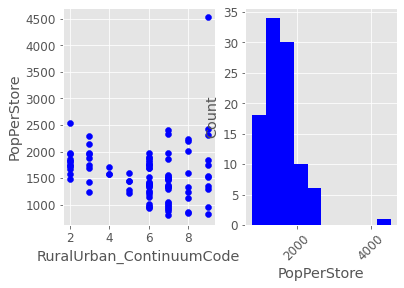

In [22]:
fig, axs = plt.subplots(1,2)
    
# Histogram
axs[1].hist(df_bycounty['PopPerStore'],color='b')
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_ylabel('Count')
axs[1].set_xlabel('PopPerStore')

# Scatter
axs[0].scatter(df_bycounty['RuralUrban_ContinuumCode'],df_bycounty['PopPerStore'],color='b')
axs[0].set_xlabel('RuralUrban_ContinuumCode')
axs[0].set_ylabel('PopPerStore')

In [168]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('Greys')
new_cmap = truncate_colormap(cmap, 0, 0.6)

In [24]:
# County Boundaries Shape File
map_counties = gpd.read_file(
    '../data/County_Boundaries_of_Iowa/geo_export_b0962504-4b8e-4a81-9f03-586d790445ed.shp')

map_counties.rename(columns={'county_nam': 'County'}, inplace=True)
map_counties = map_counties.sort_values(by=['County'])

map_counties['County'] = map_counties['County'].str.lower()
map_counties.loc[map_counties['County']=="obrien",'County']="o'brien"
map_counties.head()

,gnis_featu,fips,state_coun,County,acres,geometry
71,465190,19001,01,adair,364794.8,"POLYGON ((-94.70051 41.50434, -94.68163 41.504..."
80,465191,19003,02,adams,272218.7,"POLYGON ((-94.92751 41.15872, -94.91078 41.158..."
5,465192,19005,03,allamakee,421810.2,"POLYGON ((-91.61075 43.50060, -91.61061 43.500..."
97,465193,19007,04,appanoose,330047.6,"POLYGON ((-93.09759 40.89823, -93.07897 40.898..."
58,465194,19009,05,audubon,283755.1,"POLYGON ((-95.09285 41.86336, -95.07302 41.863..."


In [25]:
# County Points Shape File
map_counties_pts = gpd.read_file(
    '../data/Primary_Points_for_Iowa_Counties/geo_export_7ec5c31d-2f89-4961-bacf-1dbe5f7b3ed7.shp')

map_counties_pts.rename(columns={'county_nam': 'County'}, inplace=True)
map_counties_pts['County'] = map_counties_pts['County'].str.lower()

In [26]:
# Digging into the discrepancies (county names need to match)
temp2 = list(map_counties['County'].unique())
temp0 = list(df_bycounty['County'].unique())
s = set(temp2)
temp3 = [x for x in temp0 if x not in s]
temp3

[]

In [27]:
map_counties2 = map_counties.merge(df_bycounty, on = ['County'], how = 'left')
map_counties2.head()

,gnis_featu,fips,state_coun,County,acres,geometry,Annual_SalesDollars,StoreCount,Annual_VolumeSold,ProductCount,VendorCount,LandArea_sqmi,RuralUrban_ContinuumCode,Percent_CollegeGraduates,UnemploymentRate_2021,Median_Household_Income_2019,Median_GrossRent_2019,Population_Estimate_2021,Population Estimate_22to29yrs,Population Estimate_3-to44yrs,Prct_22to29,Prct_30to44,AvailableIncome,PopPerStore,StoresPer10K,SalesPerCapita,SalesPerCapita_perStore,StoresPerSqMi,SalesPerStore
0,465190,19001,01,adair,364794.8,"POLYGON ((-94.70051 41.50434, -94.68163 41.504...",683600.94,8,43177.07,621,52,569.27,8,18.5,2.7,57977,585,6888,594,1164,8.623693,16.898955,50957,861.000000,11.614402,99.245200,12.405650,0.014053,85450.117500
1,465191,19003,02,adams,272218.7,"POLYGON ((-94.92751 41.15872, -94.91078 41.158...",215545.86,2,13532.61,445,48,423.44,9,15.6,2.8,53385,549,3496,316,568,9.038902,16.247140,46797,1748.000000,5.720824,61.654994,30.827497,0.004723,107772.930000
2,465192,19005,03,allamakee,421810.2,"POLYGON ((-91.61075 43.50060, -91.61061 43.500...",1091295.24,10,77669.16,1155,66,639.08,6,17.8,3.5,56240,620,13548,1127,2165,8.318571,15.980218,48800,1354.800000,7.381163,80.550283,8.055028,0.015647,109129.524000
3,465193,19007,04,appanoose,330047.6,"POLYGON ((-93.09759 40.89823, -93.07897 40.898...",1107116.79,9,71170.37,892,53,497.29,7,16.3,4.3,41672,624,12335,1037,1900,8.406972,15.403324,34184,1370.555556,7.296311,89.754097,9.972677,0.018098,123012.976667
4,465194,19009,05,audubon,283755.1,"POLYGON ((-95.09285 41.86336, -95.07302 41.863...",288076.35,4,19729.46,642,53,442.96,8,17.1,3.1,53197,582,5338,473,806,8.860997,15.099288,46213,1334.500000,7.493443,53.967094,13.491774,0.009030,72019.087500


In [28]:
map_counties2.nlargest(5, 'StoreCount')['County']

76          polk
56          linn
6     black hawk
81         scott
51       johnson
Name: County, dtype: object

In [29]:
map_counties2.nlargest(5, 'StoresPer10K')['County'].reset_index()

,index,County
0,70,o'brien
1,75,pocahontas
2,59,lyon
3,0,adair
4,73,palo alto


In [30]:
map_counties2.nlargest(5, 'SalesPerCapita')['County'].reset_index()

,index,County
0,29,dickinson
1,16,cerro gordo
2,76,polk
3,6,black hawk
4,81,scott


In [31]:
map_counties2.nlargest(5, 'SalesPerCapita_perStore')['County'].reset_index()

,index,County
0,1,adams
1,79,ringgold
2,29,dickinson
3,46,ida
4,58,lucas


In [32]:
map_counties2.nlargest(5, 'PopPerStore')['County'].reset_index()

,index,County
0,25,davis
1,24,dallas
2,79,ringgold
3,23,crawford
4,50,jefferson


In [33]:
map_counties2.nlargest(5, 'AvailableIncome')['County'].reset_index()

,index,County
0,24,dallas
1,90,warren
2,37,grundy
3,60,madison
4,83,sioux


In [34]:
#map_counties2.nlargest(99, 'Population')['County'].reset_index()

# Map It Out

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'RuralUrban_ContinuumCode'}>

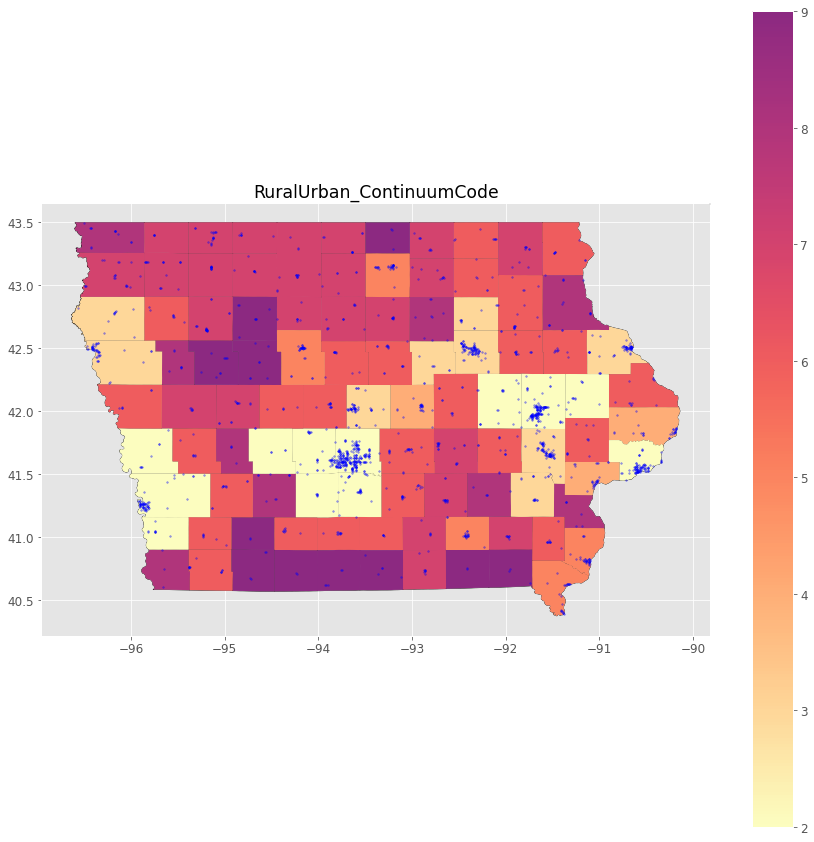

In [35]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('RuralUrban_ContinuumCode')

map_counties.plot(color='white', edgecolor='black', ax=ax)
map_counties2.plot(column='RuralUrban_ContinuumCode', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')
       
store_geo.plot(ax = ax, color="blue",markersize=3, alpha=0.40)

No handles with labels found to put in legend.


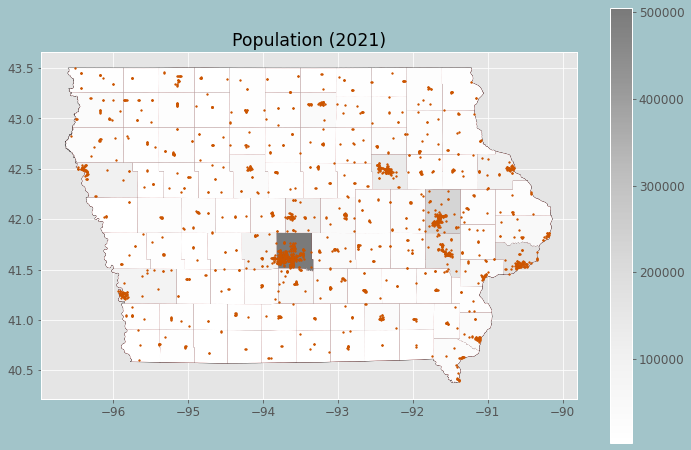

In [169]:
fig,ax = plt.subplots(figsize = (12,8))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Population (2021)')

map_counties.plot(color='red', edgecolor='black', ax=ax)
map_counties2.plot(column='Population_Estimate_2021', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')
      
store_geo.plot(ax = ax, color="#CC5500",markersize=3, alpha=1)
fig.patch.set_facecolor('#a2c4c9ff')

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Stores per 10K Residents in 2021'}>

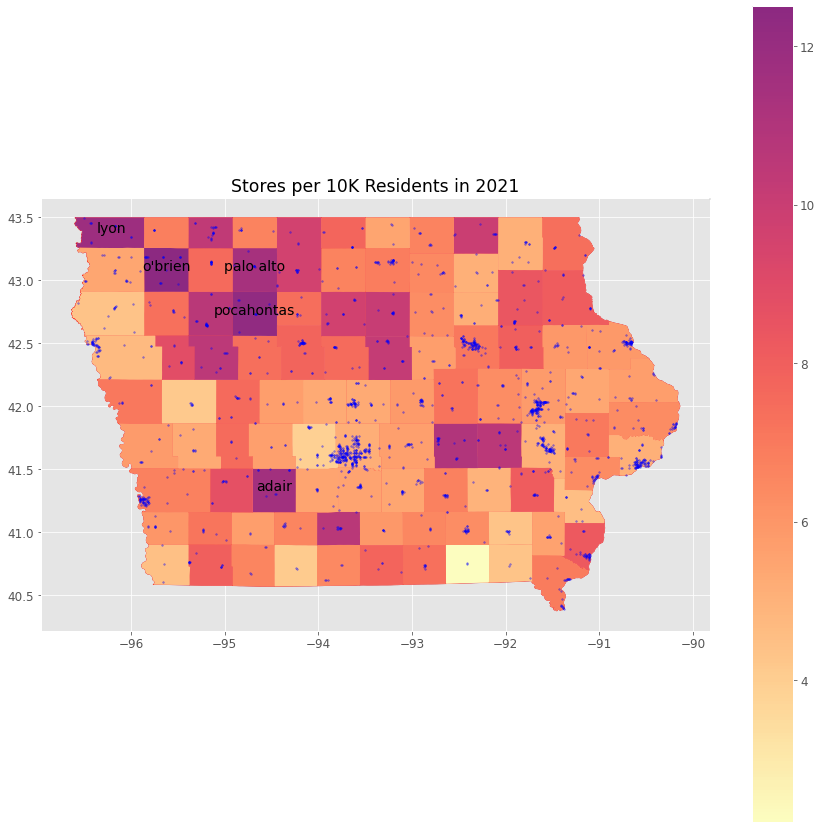

In [37]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Stores per 10K Residents in 2021')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='StoresPer10K', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    if name in ["o'brien",'pocahontas','lyon','adair','palo alto']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=14, horizontalalignment='center')

store_geo.plot(ax = ax, color="blue",markersize=3, alpha=0.40)


No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Population Per Store'}>

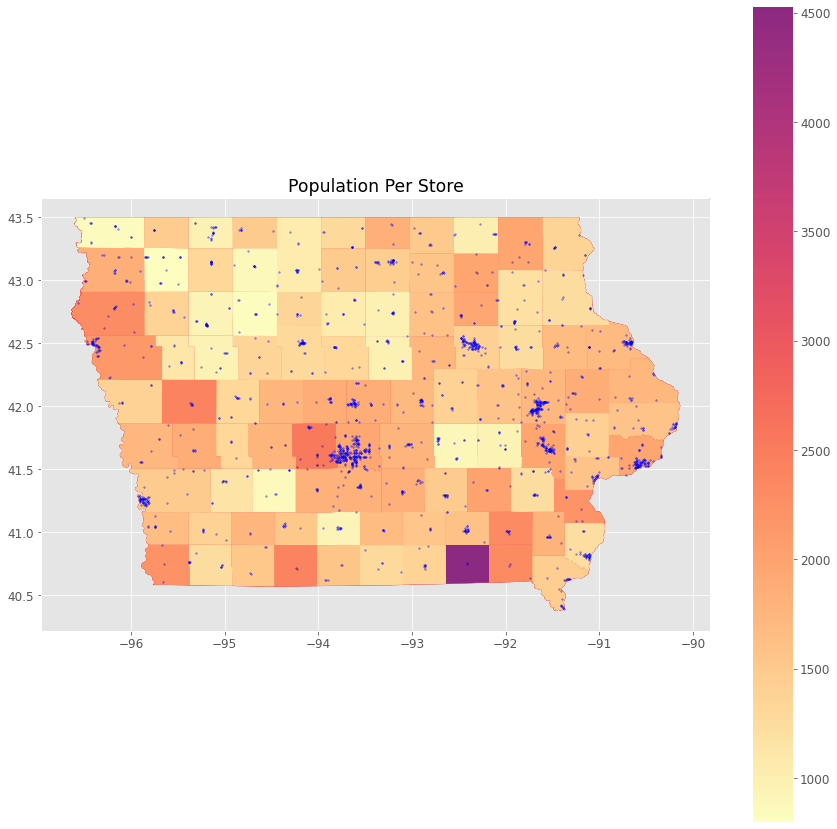

In [38]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Population Per Store')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='PopPerStore', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

#for name in map_counties_pts['County']:
#    if name in ["davis",'dallas','ringgold','crawford','jefferson']:
#        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
#        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
#        plt.text(x,y,name, fontsize=14, horizontalalignment='center')

store_geo.plot(ax = ax, color="blue",markersize=3, alpha=0.40)

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Income - Rent'}>

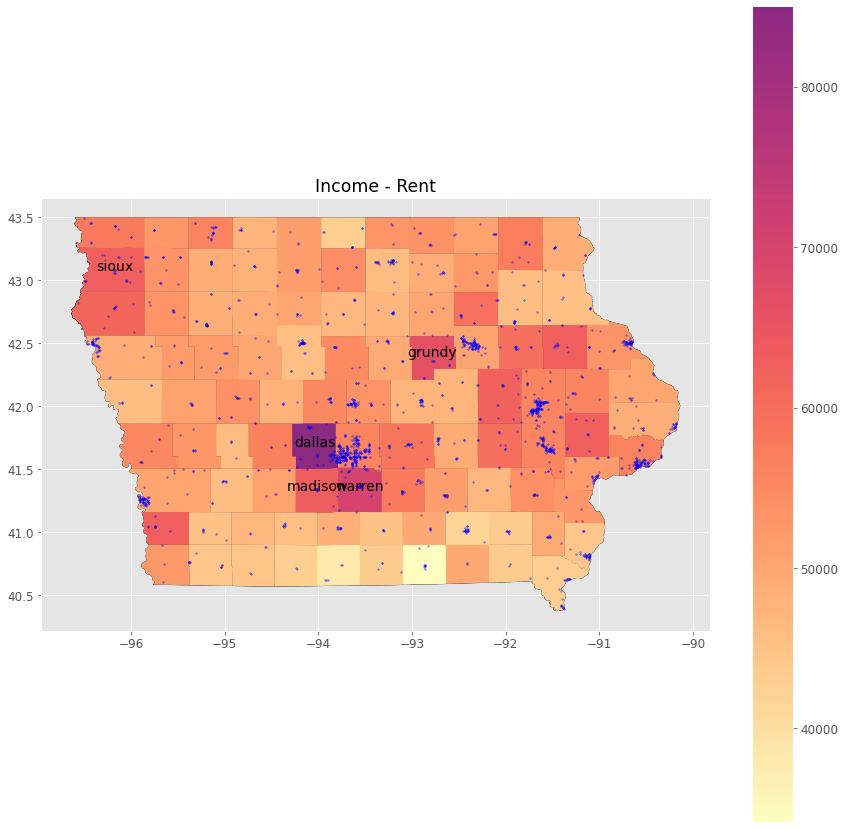

In [39]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Income - Rent')

map_counties.plot(color='white', edgecolor='black', ax=ax)
map_counties2.plot(column='AvailableIncome', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    if name in ['dallas','warren','grundy','madison','sioux']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=14, horizontalalignment='center')
        
store_geo.plot(ax = ax, color="blue",markersize=3, alpha=0.40)

# Compare Candidates

In [204]:
df_bycounty.loc[df_bycounty['County']=='polk']

,County,Annual_SalesDollars,StoreCount,Annual_VolumeSold,ProductCount,VendorCount,LandArea_sqmi,RuralUrban_ContinuumCode,Percent_CollegeGraduates,UnemploymentRate_2021,Median_Household_Income_2019,Median_GrossRent_2019,Population_Estimate_2021,Population Estimate_22to29yrs,Population Estimate_3-to44yrs,Prct_22to29,Prct_30to44,AvailableIncome,PopPerStore,StoresPer10K,SalesPerCapita,SalesPerCapita_perStore,StoresPerSqMi,SalesPerStore
76,polk,99027372.44,259,5205009.82,3620,180,573.8,2,36.7,4.2,67331,910,504735,56479,102178,11.189832,20.24389,56411,1948.783784,5.131406,196.196762,0.757516,0.451377,382345.067336


In [54]:
df_bycounty['Median_Household_Income_2019'].median()

58077.0

In [60]:
short_table = df_bycounty.loc[(df_bycounty['PopPerStore']>=2000)]
ptable = short_table[['County','Annual_SalesDollars','Population_Estimate_2021','StoreCount','PopPerStore','SalesPerStore']]
ptable.rename(columns={'PopPerStore': 'Population_PerStore',
                      'StoresPer10K': 'Stores_Per10K',
                      'Population_Estimate_2021': 'Population',
                      'Median_Household_Income_2019': 'Income'}, inplace=True)

ptable.nlargest(10,'SalesPerStore')

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,County,Annual_SalesDollars,Population,StoreCount,Population_PerStore,SalesPerStore
96,woodbury,14593632.42,102847,48,2142.645833,304034.008750
24,dallas,11530168.58,99346,39,2547.333333,295645.348205
23,crawford,1824568.43,16886,7,2412.285714,260652.632857
74,plymouth,2285269.39,25217,11,2292.454545,207751.762727
50,jefferson,1445797.01,18603,8,2325.375000,180724.626250
79,ringgold,267877.77,4840,2,2420.000000,133938.885000
88,van buren,248383.70,6938,3,2312.666667,82794.566667
25,davis,140308.27,9056,2,4528.000000,70154.135000
53,keokuk,316720.48,10045,5,2009.000000,63344.096000
57,louisa,265613.44,11013,5,2202.600000,53122.688000


In [63]:
ptable.nlargest(10,'Annual_SalesDollars')['County']

96     woodbury
24       dallas
74     plymouth
23     crawford
50    jefferson
53       keokuk
79     ringgold
57       louisa
88    van buren
25        davis
Name: County, dtype: object

No handles with labels found to put in legend.


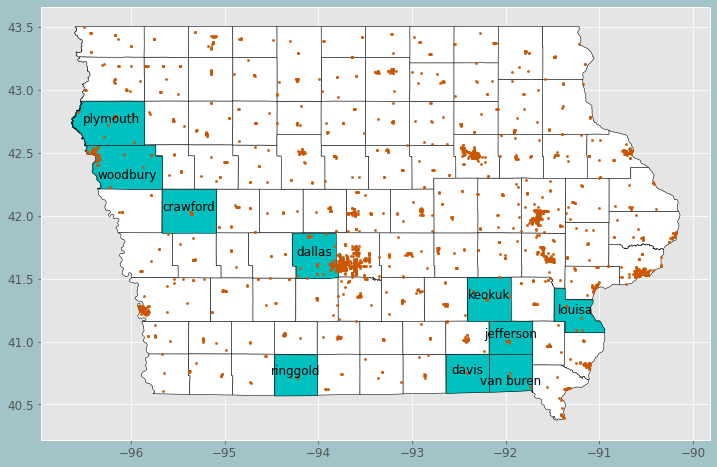

In [171]:
fig,ax = plt.subplots(figsize = (12,8))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('')

map_counties.plot(color='white', edgecolor='black', ax=ax)
#map_counties2.plot(column='PopPerStore', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

map_counties[map_counties['County']=='woodbury'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='dallas'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='plymouth'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='crawford'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='jefferson'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='keokuk'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='ringgold'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='louisa'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='van buren'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='davis'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')

for name in map_counties_pts['County']:
    if name in ['dallas','plymouth','crawford','jefferson','keokuk','ringgold','louisa','davis']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=12, horizontalalignment='center')
    if name in ['woodbury','van buren']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y-0.1,name, fontsize=12, horizontalalignment='center')       
        
store_geo.plot(ax = ax, color="#CC5500",markersize=5, alpha=1)

fig.patch.set_facecolor('#a2c4c9ff')

In [71]:
temp1.head()

,TransactionID,Date,StoreID,StoreType,ProductID,CategoryGroup,VendorID,County,lat,lng,Year,Population,Unemployment_Rate,VolumeSold_Liters,Sale_Dollars
0,INV-41517100002,2021-11-01,5417,Food & Grocery,36308,vodka,434,linn,41.88875,-91.67497,2021,230479,4.9,10.50,64.56
1,INV-41518800037,2021-11-01,4921,Food & Grocery,19061,whisky,65,linn,41.96451,-91.73978,2021,230479,4.9,0.05,10.50
2,INV-41518900014,2021-11-01,5687,Food & Grocery,11296,whisky,260,linn,41.96442,-91.72973,2021,230479,4.9,9.00,298.68
3,INV-41521200068,2021-11-01,2648,Food & Grocery,86250,liqueur,434,polk,41.56108,-93.77478,2021,504735,4.2,9.00,48.12
4,INV-41523800012,2021-11-01,4379,Convenience,52596,brandy,205,polk,41.58511,-93.78953,2021,504735,4.2,3.75,48.75


In [72]:
short_table['County'].unique()

array(['crawford', 'dallas', 'davis', 'fremont', 'jefferson', 'keokuk',
       'louisa', 'plymouth', 'ringgold', 'van buren', 'woodbury'],
      dtype=object)

In [101]:
temp2 = temp1.loc[(temp1['County']=='woodbury') |
                 (temp1['County']=='dallas') |
                 (temp1['County']=='plymouth') |
                 (temp1['County']=='crawford') |
                 (temp1['County']=='jefferson') | 
                 (temp1['County']=='keokuk') |
                 (temp1['County']=='ringgold') |
                 (temp1['County']=='louisa') |
                 (temp1['County']=='van buren') |
                 (temp1['County']=='davis')]

In [102]:
temp2.head()

,TransactionID,Date,StoreID,StoreType,ProductID,CategoryGroup,VendorID,County,lat,lng,Year,Population,Unemployment_Rate,VolumeSold_Liters,Sale_Dollars
21,INV-41565100014,2021-11-02,5800,Convenience,64864,whisky,421,woodbury,42.51494,-96.47430,2021,102847,4.2,9.0,192.00
22,INV-41565700003,2021-11-02,4884,Convenience,34433,vodka,35,woodbury,42.47072,-96.34864,2021,102847,4.2,9.0,270.00
23,INV-41566400005,2021-11-02,4568,Convenience,64867,whisky,421,woodbury,42.54233,-96.35874,2021,102847,4.2,12.0,204.12
48,INV-41630100039,2021-11-03,5316,Food & Grocery,43128,rum,35,keokuk,41.33307,-92.20607,2021,10045,4.1,7.0,90.00
80,INV-41709600008,2021-11-05,5868,Food & Grocery,45276,rum,434,davis,40.75335,-92.41277,2021,9056,3.4,9.0,72.00


In [103]:
df = temp2.groupby(['County','StoreType']).agg({'StoreID':'nunique',
                                                'Sale_Dollars':'sum'})

df.rename(columns = {'StoreID':'Count'}, inplace = True)

df['%'] = 100 * df['Sale_Dollars'] / df.groupby('County')['Sale_Dollars'].transform('sum')

df

Count  Sale_Dollars           %
County    StoreType                                              
crawford  Convenience                 1      77104.86    4.225923
          Dept. Store                 1     216411.92   11.860992
          Food & Grocery              4     984604.70   53.963704
          Liquor, Spirits & Wine      1     546446.95   29.949381
dallas    Convenience                10     726885.09    6.304202
          Dept. Store                 1    4696494.62   40.732229
          Food & Grocery             25    5089176.81   44.137922
          Liquor, Spirits & Wine      2     896917.08    7.778872
          Unknown                     1     120694.98    1.046776
davis     Food & Grocery              2     140308.27  100.000000
jefferson Convenience                 3     393971.74   27.249450
          Dept. Store                 1     295162.01   20.415176
          Food & Grocery              4     756663.26   52.335373
keokuk    Food & Grocery              5     316720.48  100.000000
louisa    Convenience                 1     117417.78   44.206265
          Food & Grocery              4     148195.66   55.793735
plymouth  Convenience                 1      88688.89    3.880894
          Dept. Store                 1     236587.20   10.352705
          Food & Grocery              6    1178167.74   51.554873
          Liquor, Spirits & Wine      3     781825.56   34.211527
ringgold  Food & Grocery              2     267877.77  100.000000
van buren Food & Grocery              3     248383.70  100.000000
woodbury  Convenience                17    1720673.13   11.790575
          Dept. Store                 6    4643497.13   31.818652
          Drugstore                   3     110535.72    0.757424
          Food & Grocery             18    5558469.17   38.088318
          Hotel/Casino                1     152870.40    1.047514
          Liquor, Spirits & Wine      3    2407586.87   16.497516

In [104]:
df=df.reset_index()

In [209]:
df['County']=pd.Categorical(df['County'],categories=['louisa','keokuk','davis','van buren','ringgold','jefferson','plymouth','crawford','dallas','woodbury'])
df=df.sort_values('County')
df

,County,StoreType,Count,Sale_Dollars,%
15,louisa,Food & Grocery,4,148195.66,55.793735
14,louisa,Convenience,1,117417.78,44.206265
13,keokuk,Food & Grocery,5,316720.48,100.000000
9,davis,Food & Grocery,2,140308.27,100.000000
21,van buren,Food & Grocery,3,248383.70,100.000000
20,ringgold,Food & Grocery,2,267877.77,100.000000
12,jefferson,Food & Grocery,4,756663.26,52.335373
11,jefferson,Dept. Store,1,295162.01,20.415176
10,jefferson,Convenience,3,393971.74,27.249450
17,plymouth,Dept. Store,1,236587.20,10.352705


In [210]:
newtable1 = df.pivot_table(values='Count', index='County', columns=['StoreType'], aggfunc=np.sum)
newtable1.fillna(0, inplace=True)
newtable1 = newtable1[['Liquor, Spirits & Wine','Food & Grocery','Convenience','Drugstore','Dept. Store','Hotel/Casino','Unknown']]
newtable1

StoreType,"Liquor, Spirits & Wine",Food & Grocery,Convenience,Drugstore,Dept. Store,Hotel/Casino,Unknown
County,,,,,,,
louisa,0,4,1,0,0,0,0
keokuk,0,5,0,0,0,0,0
davis,0,2,0,0,0,0,0
van buren,0,3,0,0,0,0,0
ringgold,0,2,0,0,0,0,0
jefferson,0,4,3,0,1,0,0
plymouth,3,6,1,0,1,0,0
crawford,1,4,1,0,1,0,0
dallas,2,25,10,0,1,0,1


In [211]:
newtable2 = df.pivot_table(values='%', index='County', columns=['StoreType'], aggfunc=np.sum)
newtable2.fillna(0, inplace=True)
newtable2 = newtable2[['Liquor, Spirits & Wine','Food & Grocery','Convenience','Drugstore','Dept. Store','Hotel/Casino','Unknown']]
newtable2

StoreType,"Liquor, Spirits & Wine",Food & Grocery,Convenience,Drugstore,Dept. Store,Hotel/Casino,Unknown
County,,,,,,,
louisa,0.000000,55.793735,44.206265,0.000000,0.000000,0.000000,0.000000
keokuk,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
davis,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
van buren,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ringgold,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
jefferson,0.000000,52.335373,27.249450,0.000000,20.415176,0.000000,0.000000
plymouth,34.211527,51.554873,3.880894,0.000000,10.352705,0.000000,0.000000
crawford,29.949381,53.963704,4.225923,0.000000,11.860992,0.000000,0.000000
dallas,7.778872,44.137922,6.304202,0.000000,40.732229,0.000000,1.046776


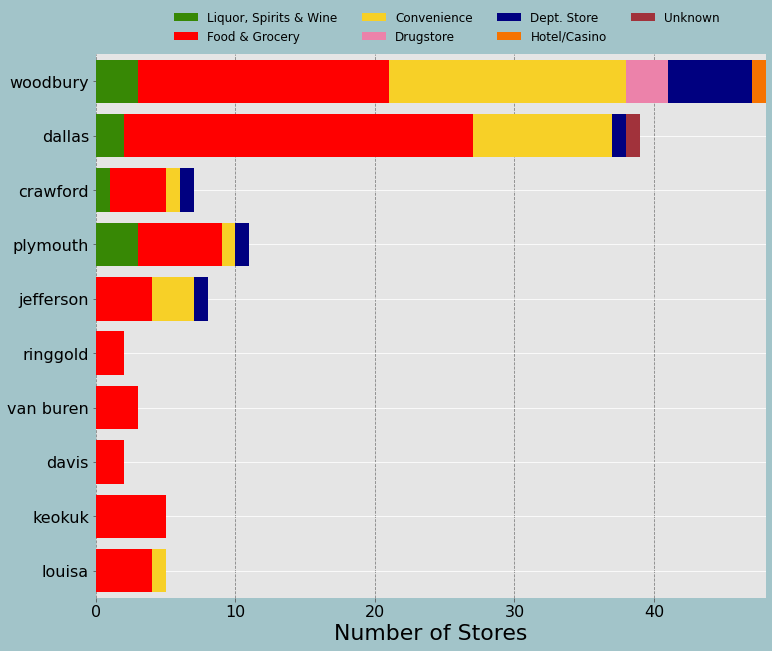

In [212]:
fields = ['Liquor, Spirits & Wine','Food & Grocery','Convenience','Drugstore','Dept. Store','Hotel/Casino','Unknown']
colors = ['#378805', 'red','#F7D027','#ec82aa','navy', '#f67300', '#a1323b']
labels = ['Liquor, Spirits & Wine','Food & Grocery','Convenience','Drugstore','Dept. Store','Hotel/Casino','Unknown']
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(newtable1) * [0]
for idx, name in enumerate(fields):
    plt.barh(newtable1.index, newtable1[name], left = left, color=colors[idx])
    left = left + newtable1[name]
# title, legend, labels
#plt.title('Competitive Landscape By County and Store Types\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.1,1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Number of Stores',fontsize=22, color = 'black')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.ylabel('', fontsize=16, color = 'black', rotation = 90)
plt.yticks(fontsize=16, color = 'black')
plt.xticks(fontsize=16, color = 'black')

fig.patch.set_facecolor('#a2c4c9ff')
plt.show()

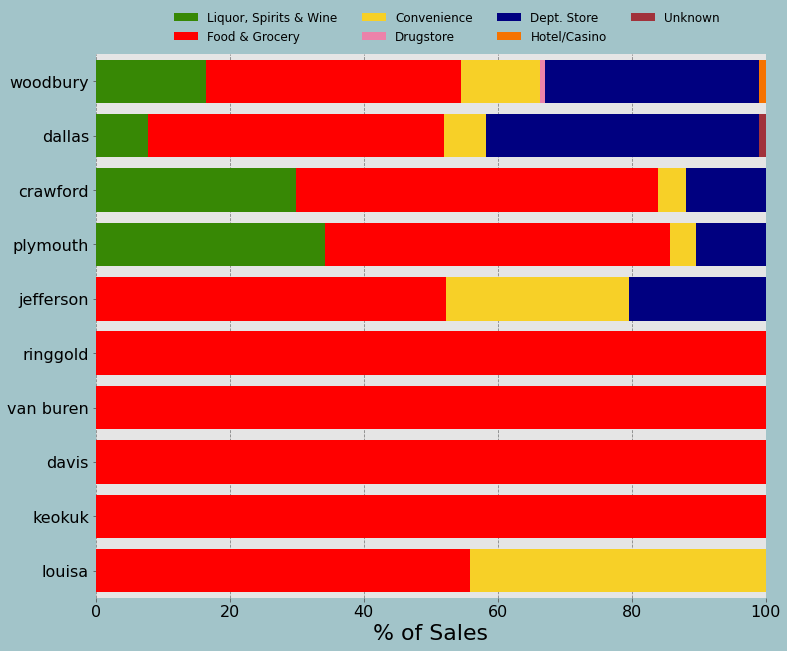

In [213]:
fields = ['Liquor, Spirits & Wine','Food & Grocery','Convenience','Drugstore','Dept. Store','Hotel/Casino','Unknown']
colors = ['#378805', 'red','#F7D027','#ec82aa','navy', '#f67300', '#a1323b']
labels = ['Liquor, Spirits & Wine','Food & Grocery','Convenience','Drugstore','Dept. Store','Hotel/Casino','Unknown']
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(newtable2) * [0]
for idx, name in enumerate(fields):
    plt.barh(newtable2.index, newtable2[name], left = left, color=colors[idx])
    left = left + newtable2[name]
# title, legend, labels
#plt.title('Competitive Landscape By County and Sales\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.10, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('% of Sales',fontsize=22, color = 'black')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.ylabel('', fontsize=16, color = 'black', rotation = 90)
plt.yticks(fontsize=16, color = 'black')
plt.xticks(fontsize=16, color = 'black')

fig.patch.set_facecolor('#a2c4c9ff')
plt.show()

In [214]:
df_cat = temp2.groupby(['County','CategoryGroup']).agg({'Sale_Dollars':'sum'})

In [215]:
df_cat['%'] = df_cat.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
df_cat

Sale_Dollars          %
County    CategoryGroup                         
crawford  brandy             81009.69   4.439937
          cocktail           36637.24   2.007995
          gin                16541.85   0.906617
          liqueur            95157.65   5.215351
          other              60016.46   3.289351
          rum               247055.40  13.540484
          schnapps           47302.00   2.592503
          spirit             17368.94   0.951948
          tequila           166674.12   9.134989
          vodka             291792.08  15.992389
          whisky            765013.00  41.928436
dallas    brandy            202086.76   1.752678
          cocktail          408363.85   3.541699
          gin               430156.85   3.730707
          liqueur           605432.64   5.250857
          other             330175.28   2.863577
          rum               850904.06   7.379806
          schnapps           72017.84   0.624604
          spirit            146925.35   1.274269
          tequila           740405.54   6.421463
          vodka            2842063.39  24.648932
          whisky           4901637.02  42.511408
davis     brandy              1845.27   1.315154
          cocktail            2749.27   1.959450
          gin                 4352.02   3.101756
          liqueur            11816.52   8.421827
          other               3684.12   2.625733
          rum                11896.28   8.478673
          schnapps            3363.60   2.397293
          spirit              1852.44   1.320264
          tequila             3294.76   2.348229
          vodka              28659.65  20.426202
          whisky             66794.34  47.605419
jefferson brandy             45083.22   3.118226
          cocktail           23238.27   1.607298
          gin                38810.53   2.684369
          liqueur            86186.17   5.961153
          other              60536.43   4.187063
          rum               132880.70   9.190827
          schnapps           24243.15   1.676802
          spirit             33546.74   2.320294
          tequila            85186.36   5.892000
          vodka             351623.01  24.320358
          whisky            564462.43  39.041610
keokuk    brandy              6293.08   1.986951
          cocktail            4581.37   1.446503
          gin                 3159.64   0.997612
          liqueur            17795.58   5.618702
          other              18435.49   5.820745
          rum                33875.32  10.695652
          schnapps            5249.19   1.657357
          spirit              5199.24   1.641586
          tequila             7869.88   2.484803
          vodka              72560.67  22.910003
          whisky            141701.02  44.740088
louisa    brandy              9288.85   3.497131
          cocktail            3747.15   1.410753
          gin                 1812.98   0.682563
          liqueur             9499.17   3.576314
          other              10659.76   4.013261
          rum                36683.53  13.810871
          schnapps            4642.22   1.747735
          spirit              1780.91   0.670489
          tequila            13497.93   5.081795
          vodka              41631.23  15.673616
          whisky            132369.71  49.835471
plymouth  brandy             56450.52   2.470191
          cocktail           40340.56   1.765243
          gin                27900.56   1.220887
          liqueur           168611.32   7.378181
          other              92058.24   4.028332
          rum               292025.92  12.778621
          schnapps           76003.12   3.325784
          spirit             40298.60   1.763407
          tequila           134255.00   5.874800
          vodka             397724.12  17.403818
          whisky            959601.43  41.990736
ringgold  brandy              2825.12   1.054630
          cocktail           10586.94   3.952153
          gin                 7364.49   2.749198
       

In [218]:
df_cat=df_cat.reset_index()
df_cat['County']=pd.Categorical(df_cat['County'],categories=['louisa','keokuk','davis','van buren','ringgold','jefferson','plymouth','crawford','dallas','woodbury'])
df_cat=df_cat.sort_values('County')
df_cat

,County,CategoryGroup,Sale_Dollars,%
58,louisa,liqueur,9499.17,3.576314
65,louisa,whisky,132369.71,49.835471
64,louisa,vodka,41631.23,15.673616
63,louisa,tequila,13497.93,5.081795
62,louisa,spirit,1780.91,0.670489
61,louisa,schnapps,4642.22,1.747735
60,louisa,rum,36683.53,13.810871
59,louisa,other,10659.76,4.013261
57,louisa,gin,1812.98,0.682563
56,louisa,cocktail,3747.15,1.410753


In [219]:
newtable3 = df_cat.pivot_table(values='%', index='County', columns=['CategoryGroup'], aggfunc=np.sum)
newtable3.fillna(0, inplace=True)
newtable3=newtable3[['whisky','vodka','rum','tequila','liqueur','brandy','cocktail','gin','schnapps','spirit','other']]
newtable3

CategoryGroup,whisky,vodka,rum,tequila,liqueur,brandy,cocktail,gin,schnapps,spirit,other
County,,,,,,,,,,,
louisa,49.835471,15.673616,13.810871,5.081795,3.576314,3.497131,1.410753,0.682563,1.747735,0.670489,4.013261
keokuk,44.740088,22.910003,10.695652,2.484803,5.618702,1.986951,1.446503,0.997612,1.657357,1.641586,5.820745
davis,47.605419,20.426202,8.478673,2.348229,8.421827,1.315154,1.959450,3.101756,2.397293,1.320264,2.625733
van buren,48.067546,20.042459,10.930782,3.581668,7.478965,0.537000,1.302783,1.064583,3.879143,0.427057,2.688015
ringgold,47.110094,20.589241,7.404870,4.009418,7.491402,1.054630,3.952153,2.749198,3.507357,0.220063,1.911573
jefferson,39.041610,24.320358,9.190827,5.892000,5.961153,3.118226,1.607298,2.684369,1.676802,2.320294,4.187063
plymouth,41.990736,17.403818,12.778621,5.874800,7.378181,2.470191,1.765243,1.220887,3.325784,1.763407,4.028332
crawford,41.928436,15.992389,13.540484,9.134989,5.215351,4.439937,2.007995,0.906617,2.592503,0.951948,3.289351
dallas,42.511408,24.648932,7.379806,6.421463,5.250857,1.752678,3.541699,3.730707,0.624604,1.274269,2.863577


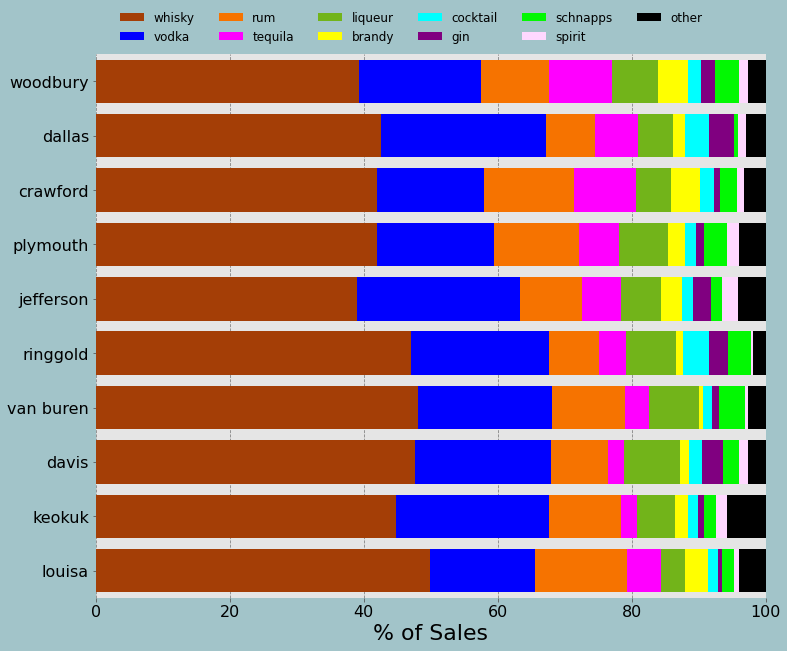

In [220]:
fields = ['whisky','vodka','rum','tequila','liqueur','brandy','cocktail','gin','schnapps','spirit','other']
colors = ['#a43e06','blue','#f67300','magenta','#72b41a','yellow','cyan','purple','#02f802','#ffd8ff','black']
labels = ['whisky','vodka','rum','tequila','liqueur','brandy','cocktail','gin','schnapps','spirit','other']
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(newtable3) * [0]
for idx, name in enumerate(fields):
    plt.barh(newtable3.index, newtable3[name], left = left, color=colors[idx])
    left = left + newtable3[name]
# title, legend, labels
#plt.title('Competitive Landscape By County and Sales\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.02, 1, 0, 0]), ncol=6, frameon=False)
plt.xlabel('% of Sales',fontsize=22, color = 'black')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.ylabel('', fontsize=16, color = 'black', rotation = 90)
plt.yticks(fontsize=16, color = 'black')
plt.xticks(fontsize=16, color = 'black')

plt.xlim(0,100)
fig.patch.set_facecolor('#a2c4c9ff')

plt.show()

No handles with labels found to put in legend.


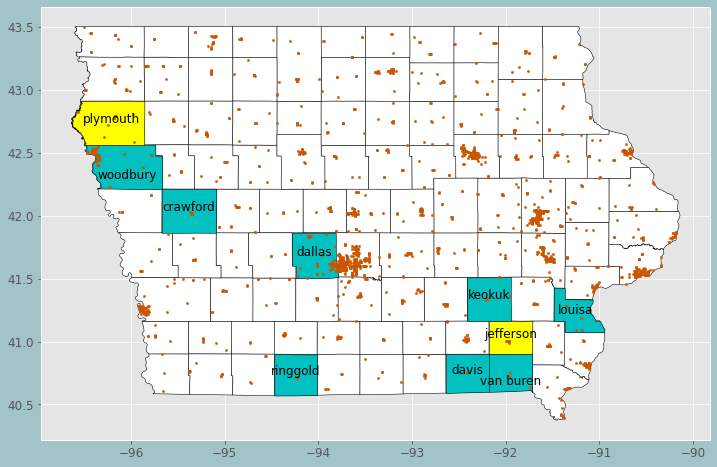

In [222]:
fig,ax = plt.subplots(figsize = (12,8))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('')

map_counties.plot(color='white', edgecolor='black', ax=ax)
#map_counties2.plot(column='PopPerStore', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

map_counties[map_counties['County']=='woodbury'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='dallas'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='plymouth'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="yellow",edgecolor='black')
map_counties[map_counties['County']=='crawford'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='jefferson'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="yellow",edgecolor='black')
map_counties[map_counties['County']=='keokuk'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='ringgold'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='louisa'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='van buren'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')
map_counties[map_counties['County']=='davis'].to_crs(epsg=4326).plot(
    ax = ax, alpha=1, color="#00c0c0",edgecolor='black')

for name in map_counties_pts['County']:
    if name in ['dallas','plymouth','crawford','jefferson','keokuk','ringgold','louisa','davis']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=12, horizontalalignment='center')
    if name in ['woodbury','van buren']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y-0.1,name, fontsize=12, horizontalalignment='center')       
        
store_geo.plot(ax = ax, color="#CC5500",markersize=5, alpha=1)

fig.patch.set_facecolor('#a2c4c9ff')

In [224]:
temp2.loc[(temp2['County']=='plymouth')&(temp2['StoreType']=='Liquor, Spirits & Wine')].groupby(['StoreType','StoreID']).agg({'Sale_Dollars':'sum'})

Sale_Dollars
StoreType              StoreID              
Liquor, Spirits & Wine 3695        158078.04
                       4277        352167.54
                       5431        271579.98

In [227]:
last = temp2.loc[(temp2['StoreType']=='Liquor, Spirits & Wine')].groupby(['County','StoreID']).agg({'Sale_Dollars':'sum'})
last

Sale_Dollars
County   StoreID              
crawford 5728        546446.95
dallas   6087        124042.39
         6242        772874.69
plymouth 3695        158078.04
         4277        352167.54
         5431        271579.98
woodbury 3820       1390028.92
         5351        934744.82
         6148         82813.13

In [233]:
last.groupby('County').agg({'Sale_Dollars':'sum'}).sort_values('Sale_Dollars')

,Sale_Dollars
County,
crawford,546446.95
plymouth,781825.56
dallas,896917.08
woodbury,2407586.87
